In [39]:
import numpy as np
import h5py
import os
import scipy.io
import tensorflow as tf
import math


# Path to 3d tensor. Tensor.shape is (50,50,100)
tensor_path = '../pc_real_bias_nolookat_remove_noise/train/'
#val_path = '../pc_real_bias_nolookat_remove_noise/val_onlynewdata_noking/'
val_path = '../pc_test/val/'
#datas = np.zeros((1,50,50,100));
#labels = np.zeros((1,6));
filelist = []
val_list = []
print(os.listdir(tensor_path))
'''
file = open("filelist.txt","r")
for line in file:
    filelist.append(line[:-1])
    #temp = np.zeros((1,6))        
    #temp[0][int(line[0])] = 1    
    #labels = np.concatenate((labels,temp),axis = 0)
    #print(line)
    #print(line[0])
    
file.close()
#print(filelist)
#read data

'''
for dirname in os.listdir(val_path):
    print(dirname)
    for filename in os.listdir(val_path+'/'+dirname):
        val_list.append(dirname+'/'+filename)
        
for dirname in os.listdir(tensor_path):
    print(dirname)
    for filename in os.listdir(tensor_path+'/'+dirname):
        filelist.append(dirname+'/'+filename)
        #f = h5py.File(tensor_path+dirname+'/'+filename)
        #pc = np.array(f['answer'])
        #datas  = np.concatenate((datas,pc[np.newaxis,...]),axis = 0)
        #temp = np.zeros((1,6))        
        #temp[0][int(dirname)] = 1
        #labels = np.concatenate((labels,temp),axis = 0)
        #f.close()


#print(filelist)
#datas = datas[1:datas.shape[0],:,:,:]
#labels = labels[1:labels.shape[0],:]     #delete first labels
print(len(filelist))
print(len(val_list))
#print(labels.shape)
# Graph
batch_size = 64
num_labels = 6


['5', '3', '1', '2', '0', '4']
5
3
1
2
0
4
5
3
1
2
0
4
324000
2484


In [40]:
def read_data(root,path):
    f = h5py.File(root+path)
    data = np.array(f['answer'])
    f.close()
    labels = np.zeros((1,num_labels)) 
    #labels = labels - 1
    #labels[0] = int(path[0])
    labels[0][int(path[0])] = 1
    return data, labels

In [41]:
# Accuracy function
def get_accuracy(predictions, labels):
  gt = tf.argmax(labels,1)
  prediction = tf.argmax(predictions,1)
  singleacc = tf.reduce_sum(tf.cast(tf.equal(prediction, gt), tf.float32))
  accuracy = 100 * tf.reduce_mean(tf.cast(tf.equal(prediction, gt), tf.float32))
  #singleacc = tf.reduce_sum(tf.cast(tf.equal(tf.argmax(predictions,1), tf.argmax(labels,1)), tf.float32))
  #accuracy = 100 * tf.reduce_mean(tf.cast(tf.equal(tf.argmax(predictions,1), tf.argmax(labels,1)), tf.float32))
  return  gt,prediction, singleacc, accuracy




In [42]:
def bn(input,depth):
    batch_mean,batch_variance = tf.nn.moments(input, [0,1,2,3], name='moments')
    #scale1 = tf.Variable(tf.ones([24,24,49,32]))
    #beta1 = tf.Variable(tf.zeros([24,24,49,32]))
    beta = tf.Variable(tf.constant(0.0, shape=[depth]), name='beta', trainable=True)
    gamma = tf.Variable(tf.constant(1.0, shape=[depth]), name='gamma', trainable=True)
    ema = tf.train.ExponentialMovingAverage(decay=0.5)
    epsilon = 1e-3
        
    def mean_var_with_update():
        ema_apply_op = ema.apply([batch_mean, batch_variance])
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_variance)
        
    pred = tf.placeholder(tf.bool)
    pred =  tf.Variable(True,  name='pred')
    #pred = True
    #print(type(pred))
    mean, var = tf.cond(pred, mean_var_with_update, lambda: (ema.average(batch_mean), ema.average(batch_variance)))
    #mean,var = mean_var_with_update
    BN = tf.nn.batch_normalization(input,mean,var,beta,gamma,epsilon)
    return BN
    #print(BN1)

In [43]:
def leakyrelu(x, alpha=0., max_value = None):
    '''ReLU.
    alpha: slope of negative section.
    '''
    negative_part = tf.nn.relu(-x)
    x = tf.nn.relu(x)
    #if max_value is not None:
    #    x = tf.clip_by_value(x, tf.cast(0., dtype=_FLOATX),
    #                         tf.cast(max_value, dtype=_FLOATX))
    x -= tf.constant(alpha, dtype=tf.float32) * negative_part
    return x

In [44]:
graph = tf.Graph()

with graph.as_default():

    predict = tf.Variable(False)
    # Input data.
    with tf.name_scope('data') as scope:
        tf_train_dataset = tf.placeholder(tf.float32, shape=(None, 50, 50, 100, 1), name = "tf_train_dataset")
        tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels), name = "tf_train_labels")

    # Variables.
    with tf.name_scope('conv1') as scope:
	#conv1
        stdv = 1/math.sqrt(5*5*5*1)
        #tf.random_uniform
        conv1_w = tf.Variable(tf.random_uniform([5, 5, 5, 1, 32], -stdv, stdv ), name = "conv1_w")
        conv1_bias = tf.Variable(tf.random_uniform([32], -stdv, stdv ), name = "conv1_bias")

        #tf.add_to_collection('vars', layer1_weights)
        #tf.add_to_collection('vars', layer1_biases)
    #layer1_biases = tf.Variable(tf.constant(1.0, shape=[32]))#tf.zeros([32])
    with tf.name_scope('conv2') as scope:
	#conv2
        stdv = 1/math.sqrt(3*3*3*32)
        conv2_w = tf.Variable(tf.random_uniform([3, 3, 3, 32, 32], -stdv, stdv ), name = "conv2_w")   
        conv2_bias = tf.Variable(tf.random_uniform([32], -stdv, stdv ), name = "conv2_bias")
        
        #tf.add_to_collection('vars', layer2_weights)
        #tf.add_to_collection('vars', layer2_biases)
    #layer2_biases = tf.Variable(tf.constant(1.0, shape=[32]))
    with tf.name_scope('fc1') as scope:
    #fc1        
        stdv = 1/math.sqrt(11*11*23*32)
        fc1_w = tf.Variable(tf.random_uniform([11*11*23*32, 128], -stdv, stdv), name = "fc1_w")
        #layer3_weights = tf.Variable(tf.random_normal([11*11*23*32, 128]), name = "fc1_w")
        fc1_bias = tf.Variable(tf.random_uniform([128]), name = "fc1_bias")    
        
        #tf.add_to_collection('vars', layer3_weights)
        #tf.add_to_collection('vars', layer3_biases)
    #layer3_biases = tf.Variable(tf.constant(1.0, shape=[128]))
    with tf.name_scope('fc2') as scope:
	#fc2
        stdv = 1/math.sqrt(128)
        fc2_w = tf.Variable(tf.random_uniform([128, num_labels], -stdv, stdv), name = "fc2_w")
        #layer4_weights = tf.Variable(tf.random_normal([128, num_labels]), name = "fc2_w")
        fc2_bias = tf.Variable(tf.random_uniform([num_labels]), name = "fc2_bias")
        
        #tf.add_to_collection('vars', layer4_weights)
        #tf.add_to_collection('vars', layer4_biases)
    #layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))


    #MODEL     
    def model(data):
        # Conv1
        padding = [[0,0],[1,1],[1,1],[1,1],[0,0]]
        padded_input = tf.pad(data,padding,"CONSTANT")
        #print(padded_input)        
        conv1 = tf.nn.conv3d(padded_input, conv1_w, [1, 2, 2, 2, 1], padding='VALID')
        #print(conv1)               
        
        #bias1 = conv1 + layer1_biases
        
        #BN1
        BN1 = bn(conv1,32)
        
        #hidden1 = tf.nn.relu(tf.nn.bias_add(conv1,conv1_bias))
        #hidden1 = tf.maximum(0.1*bias1,bias1)
        hidden1 = leakyrelu(tf.nn.bias_add(BN1,conv1_bias),0.1)
        #print(hidden1)
        #print(list(range(len(hidden1.get_shape())-1)))
                
        
        #print(hidden1)
        dropout1 = tf.nn.dropout(hidden1, 0.8)   #keep probability
        #print(dropout1)
        
        
        # Conv2
        conv2 = tf.nn.conv3d(dropout1, conv2_w, [1, 1, 1, 1, 1],padding='VALID')
        #print(conv2)
        #bias2 = conv2 + layer2_biases
        #hidden2 = tf.maximum(0.1*bias2,bias2)
        #hidden2 = tf.nn.relu(tf.nn.bias_add(conv2,conv2_bias))
        
        
        hidden2 = leakyrelu(tf.nn.bias_add(conv2,conv2_bias),0.1)
        #dropout2 = tf.nn.dropout(hidden2, 0.7)
        #print(hidden2)
        #BN2
        BN2 = bn(hidden2,32)
		
        
		#Pool1
        pool1 = tf.nn.max_pool3d(BN2, ksize=[1, 2, 2, 2, 1], strides=[1, 2, 2, 2, 1], padding='VALID')
        #print(pool1)
        dropout2 = tf.nn.dropout(pool1, 0.7)
        #print(dropout2)
        
        normalize3_flat = tf.reshape(dropout2, [-1, 11*11*23*32])
        

        #FC1
        fc1 = tf.add(tf.matmul(normalize3_flat, fc1_w) , fc1_bias)
        #print(fc1)
        #fc1 = tf.add(tf.matmul(normalize3_flat, layer3_weights), layer3_biases)
        hidden3 = tf.nn.relu(fc1)  
        #print(hidden3)
        dropout3 = tf.nn.dropout(hidden3, 0.6)
        #print(dropout3)

        #FC2                
        res = tf.add(tf.matmul(dropout3, fc2_w) , fc2_bias )
        #print(res)
        return res

    
    # Training computation
    local_res= model(tf_train_dataset)#

    with tf.name_scope("cost_function") as scope:
    #temp = tf.nn.log_softmax(local_res)
    #cross_entropy = tf.reduce_mean(-tf.reduce_sum(tf_train_labels * tf.nn.log_softmax(local_res), reduction_indices=[1]))
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = local_res))
    #print(tf_train_labels)
    #print(local_res)
    #cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = local_res))
    tf.scalar_summary("cost_function", cross_entropy)
    
        #print(local_res)
        #print(tf_train_labels)
    
    # Optimizer
    train_step = tf.train.MomentumOptimizer(0.01, 0.9).minimize(cross_entropy)
    #train_step = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)
    #train_step = tf.train.GradientDescentOptimizer(0.00001).minimize(cross_entropy)
    # Predictions for the training, validation, and test data
    with tf.name_scope("accuracy") as scope:
        gt, prediction, singleacc ,accuracy = get_accuracy(local_res, tf_train_labels)
    tf.scalar_summary("accuracy", accuracy)


    valid_prediction = tf.nn.softmax(model(tf_train_dataset))
    print ('Graph was built')
    
    merged_summary_op = tf.merge_all_summaries()       

Graph was built


In [46]:
# Session
epochs = 1
#each epochs will see all images
steps_per_epoch = int(len(filelist)/batch_size) + 1
if (len(filelist) % batch_size) == 0:
    steps_per_epoch -= 1
print ('STEPS %d' % steps_per_epoch)

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
with tf.Session(graph=graph,config=tf.ConfigProto(gpu_options=gpu_options)) as session:    
    train_writer = tf.train.SummaryWriter('./', session.graph)
    saver = tf.train.Saver(tf.all_variables())
    session.run(tf.initialize_all_variables())
    
    saver.restore(session, './itrichess_withbn.ckpt')
    
    #val
    val_pred = 0  
    confusion_matrix = np.zeros((num_labels,num_labels))
    for j in range(len(val_list)):
        #print(val_list[j])
        pc, singlelabel = read_data(val_path,val_list[j])
        pc = pc[None,:,:,:,None].astype('float32')
        val_prediction, val_label, val_acc,_ = session.run([prediction,gt,singleacc, merged_summary_op],
                                             feed_dict={tf_train_dataset: pc, tf_train_labels: singlelabel})

        for con_index in range(len(val_prediction)):
            confusion_matrix[val_label[con_index]][val_prediction[con_index]] += 1 

        val_pred = val_pred + val_acc
    val_accuracy = 100*val_pred/len(val_list)
    print(confusion_matrix)
    print("Epoch %d val accuracy: %.1f%%" % (1, val_accuracy))

    #saver.save(session, 'itrichess_withbn_before_after.ckpt')
            
            


STEPS 5063
[[ 342.   96.   13.    7.    0.   28.]
 [   0.  250.   16.    7.  108.    1.]
 [   1.   46.  286.    0.   27.   30.]
 [   1.   15.    0.  372.    0.   60.]
 [   0.   13.    5.    7.  362.    3.]
 [   0.   37.    0.   36.    0.  315.]]
Epoch 1 val accuracy: 77.6%


In [ ]:
def plot3(a,b,c,mark="o",col="r"):
  from matplotlib import pyplot
  import pylab
  from mpl_toolkits.mplot3d import Axes3D
  pylab.ion()
  fig = pylab.figure()
  ax = Axes3D(fig)
  ax.scatter(a, b, c,marker=mark,color=col)

(50, 50, 100)
[-1. -1. -1. -1. -1.  1.]


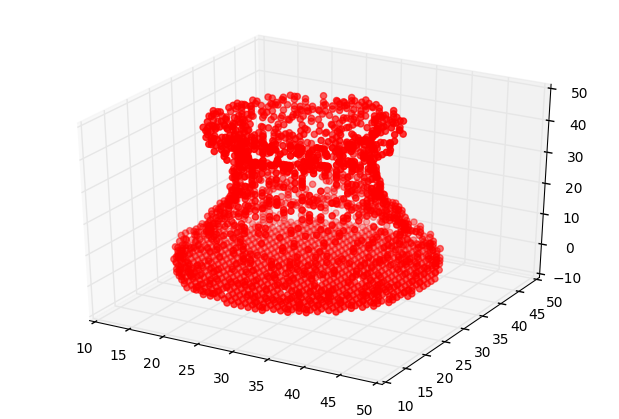

In [37]:
datatemp = batch_data[3]
datatemp= np.squeeze(datatemp)
print(datatemp.shape)
x,y,z = np.nonzero(datatemp)
plot3(x,y,z)
print(batch_labels[3])
#print x

In [50]:
print filelist
np.random.shuffle(filelist)
print filelist
arr = np.arange(len(filelist))
print(arr)
np.random.shuffle(arr)
print arr

['3/result_65.mat', '1/result_64.mat', '2/result_65.mat', '4/result_63.mat', '3/result_62.mat', '5/result_64.mat', '2/result_61.mat', '1/result_62.mat', '1/result_61.mat', '2/result_64.mat', '1/result_65.mat', '0/result_64.mat', '3/result_64.mat', '5/result_65.mat', '3/result_63.mat', '3/result_61.mat', '4/result_64.mat', '1/result_63.mat', '0/result_65.mat', '0/result_62.mat', '4/result_62.mat', '4/result_61.mat', '5/result_62.mat', '4/result_65.mat', '5/result_63.mat', '0/result_63.mat', '0/result_61.mat', '5/result_61.mat', '2/result_63.mat', '2/result_62.mat']
['4/result_65.mat', '2/result_65.mat', '5/result_64.mat', '1/result_65.mat', '2/result_64.mat', '4/result_61.mat', '0/result_62.mat', '2/result_63.mat', '1/result_62.mat', '0/result_61.mat', '0/result_64.mat', '1/result_64.mat', '0/result_63.mat', '0/result_65.mat', '2/result_62.mat', '2/result_61.mat', '3/result_61.mat', '3/result_65.mat', '1/result_61.mat', '4/result_62.mat', '3/result_62.mat', '4/result_63.mat', '3/result_